<h1 align=center><font size = 5>House Price Index and Venue Based Location Selection</font></h1>
<h1 align=center><font size = 4>Capstone Project for Applied Data Science course by IBM/Coursera</font></h1>


## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)
* [Reference](#reference)



## Introduction: Business Problem <a name="introduction"></a>


The Washington D.C. Metropolitan Area is the metropolitan area centered on Washington, D.C., the capital of the United States. The area includes all of the District of Columbia,   and parts of the US States of Virginia, Maryland and West Virginia.  Northern Virginia (locally referred to as NoVA or NOVA) comprises cities and counties in Virginia surrounding Washington D.C.

It is the most populous region of Virginia and Washington Metropolitan area. There are about 3.5million people working in various jobs in this area.

DC is home to all types of amenities and attractions.  World famous Smithsonian Museums are based in D.C. 
D.C. Metro Area boasts of hundreds of Performing Arts/theaters, public transportation, metro rail systems, Convention Halls, and Resorts etc... List is endless.

When people want to retire, they move out of DC area to have a relaxed retirement life. Many though, want to live close to DC with similar amenities and if desired, make a trip to D. C. area.

According to Kiplinger Personal Finance magazine[1], in its list of ’12 Smart Places to Retire’ lists Richmond, Virginia as one of the top in the list.

When people move, they want to make sure place has needed amenities and can move out quickly, if it does not suit them.  House Price Index (HPI) measures the price changes of residential housing. HPI is a weighted, repeat sales index, measuring average price changes in repeat sales or refinancings on the same properties[2].


HPI can be used to evaluate whether place is worth moving in without incurring a huge financial loss. The project tries to cluster Richmond area neighborhoods with Northern Virginia neighborhoods, based on Venues. Then, show areas with HPI and Venue along with cluster information, for making a informed decision about where to move within Richmond. 



## Data <a name="data"></a>

Following data will be used:
 For ease of identifying neighborhood, each Zip Code is considered as a Neighborhood. 
Thus, a file with Zip code and its longitude and latitude is needed for use with Foursquare API.
US state of Virginia specific zipcode data is downloaded from website[3] 

The file is edited to have just Zip, City, State, Latitude and Longitude, values for places in Northern Virginia (NOVA) and Richmond, VA , in a CSV format and saved as NOVA_city_richmond_selected.csv.

House Price Index is available by Zip Code at web site[4].
Downloaded Five-Digit ZIP Codes (Developmental Index; Not Seasonally Adjusted) XLSX file.

The file has following columns:
Five-Digit ZIP Code,	Year,	Annual Change (%),	HPI,	HPI with 1990 base,	HPI with 2000 base.

The downloaded file was filtered for data of  Zip Code from 20001 thru 24000, year=2018 and created a CSV file HPI_AT_BDL_ZIP5_2018_VA.csv with following column : Five-Digit ZIP Code, Year, Annual Change (%),HPI.

NOVA_city_richmond_selected.csv fil merged with HPI_AT_BDL_ZIP5_2018_VA.csv file by Zip Code.  This will make sure any combined data will have both geo-coordinates and HPI values. 
The combined data will be stored in pandas dataframe as nova_data.
 


Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
 
#!pip install geopy  # uncomment this line if you don't have it 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

#     Download and Explore Dataset

Northern Virginia[5], locally referred to as NOVA or NoVA, comprises several counties and independent cities in the Commonwealth of Virginia in the United States. It is a widespread region radiating westward and southward from Washington, D.C. With an estimated 3,149,413 residents in 2018 (36.97 percent of Virginia's total population), it is the most populous region of Virginia and the Washington metropolitan area[6]. 
For the study, major parts of Fairfax and Loudoun County are included. It is combined with data for Richmond area.

The file was filtered for state orther filtered for localities of NOVA and saved as NOVA_city_selected.csv.
To compare the neighborhoods of Richmond, created a separate Richmond area file called Richmond_area_zipcodes.csv
The file has a header identifying column names. Zip will be used as a neighborhood.

Some zipcodes share the name of the major city. All Richmond area zip codes have Richmond as city name.

The files are:

    a. NOVA_city_richmond_selected.csv      
    b. HPI_AT_BDL_ZIP5_2018_VA.csv
    

In [2]:
# read nova_data
nova_data = pd.read_csv("NOVA_city_richmond_selected.csv")
print('Data downloaded!')

Data downloaded!


In [3]:
nova_data.head() # look for first few rows

,Zip,City,State,Latitude,Longitude
0,22334,Alexandria,VA,38.815762,-77.090050
1,22307,Alexandria,VA,38.774863,-77.059300
2,22302,Alexandria,VA,38.829512,-77.082040
3,20172,Herndon,VA,38.831813,-77.288755
4,22333,Alexandria,VA,38.815762,-77.090050


In [4]:
#each Zipcode is like a neighborhood. Rename column name to Neighborhood
nova_data.rename(columns={'Zip':'Neighborhood'}, inplace=True)
#just to make data is intact display first 5 rows
nova_data.head()

,Neighborhood,City,State,Latitude,Longitude
0,22334,Alexandria,VA,38.815762,-77.090050
1,22307,Alexandria,VA,38.774863,-77.059300
2,22302,Alexandria,VA,38.829512,-77.082040
3,20172,Herndon,VA,38.831813,-77.288755
4,22333,Alexandria,VA,38.815762,-77.090050


And make sure that the dataset has all 20 Cities and 145 neighborhoods.

In [5]:
print('The dataframe has {} Cities and {} Neighborhoods.'.format(
        len(nova_data['City'].unique()),
        nova_data.shape[0]
    )
)

The dataframe has 19 Cities and 144 Neighborhoods.


#### Fairfax is centre of Northern Virginia. Use geopy library to get the latitude and longitude values of Fairfax, VA

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [6]:
address = 'Fairfax, VA'

geolocator = Nominatim(user_agent="nova_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Fairfax, VA are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Fairfax, VA are 38.8462236, -77.3063733.


#### Create a map of  Northern Virginia  with neighborhoods superimposed on top.

In [7]:
# create map of Northern Virginia  using latitude and longitude values
map_nova = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, City, Zip in  zip(nova_data['Latitude'], nova_data['Longitude'], nova_data['City'], nova_data['Neighborhood']):
    label = '{}, {}'.format(Zip, City)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nova)  
    
map_nova

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood (Zipcode) and its respective City names.

#### Read the file containg Housing Price Index (HPI) and merge with nova_data to get a dataset with HPI.



In [8]:
hpi_data = pd.read_csv("HPI_AT_BDL_ZIP5_2018_VA.csv")
print('HPI Data read!') 

HPI Data read!


In [9]:
# show first few rows of hpi_data
hpi_data.head()

,Five-Digit ZIP Code,Year,Annual Change (%),HPI
0,20001,2018,5.24,1255.38
1,20002,2018,8.86,1662.06
2,20003,2018,1.79,1119.11
3,20007,2018,3.56,1111.88
4,20008,2018,12.89,590.61


Year column is a constant for all zip cods. We can remove Year column. For later use and merge, rename Five-Digit Zip Code as Neighborhood


In [10]:
#drop Year
hpi_data=hpi_data.drop(['Year'],axis=1)
# rename column
hpi_data.rename(columns={'Five-Digit ZIP Code':'Neighborhood'}, inplace=True)
hpi_data.head()

,Neighborhood,Annual Change (%),HPI
0,20001,5.24,1255.38
1,20002,8.86,1662.06
2,20003,1.79,1119.11
3,20007,3.56,1111.88
4,20008,12.89,590.61


In [11]:
#merge nova_data and hpi_data to get updated nova_data
nova_data=nova_data.merge(hpi_data,how='inner',on='Neighborhood',validate='one_to_one')
nova_data.head()

,Neighborhood,City,State,Latitude,Longitude,Annual Change (%),HPI
0,22307,Alexandria,VA,38.774863,-77.05930,4.63,684.13
1,22302,Alexandria,VA,38.829512,-77.08204,3.52,1037.07
2,22043,Falls Church,VA,38.901311,-77.19777,-0.47,1057.79
3,22308,Alexandria,VA,38.728464,-77.05701,0.51,902.73
4,20176,Leesburg,VA,39.138978,-77.54519,1.57,321.89


Let us find out the resulting Neighborhoods with HPI data

In [12]:
nova_data.shape

(62, 7)

## Methodology <a name="methodology"></a>

Using nova_data, call FourSquare API[6] to get Venue details for each Zip Code (renamed as Neighborhood for consistency with Battle of Neighborhood theme).
Once Venue data is obtained, do following steps:
1.	Identify top 10 Venues for each Neighborhood.
2.	Normalize the data,
3.	Use K-Mean clustering to cluster the data
4.	Show cluster on a folium map.
5.	Create range for HPI
6.	Show HPI data, cluster data on a Folium map
 

#### Define Foursquare Credentials and Version

In [13]:
# read Foursquare credential from a file
#The file has CLIENT_ID in first line and CLIENT_SECRET in second line
f=open("Fsquare_credfile.txt","r")
lines=f.readlines()
CLIENT_ID=lines[0]
CLIENT_SECRET=lines[1]
f.close()
VERSION = '20180605' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [14]:
nova_data.loc[0, 'Neighborhood']

22307

Get the neighborhood's latitude and longitude values.

In [15]:
neighborhood_latitude = nova_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = nova_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_zip = nova_data.loc[0, 'Neighborhood'] # neighborhood zip code

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_zip, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of 22307 are 38.774863, -77.0593.


#### Now, let's get the top 100 venues that are in  Zipcode 22307 (Alexandria, VA)  within a radius of 10000 meters.

First, let's create the GET request URL. Name your URL **url**.

In [16]:
# set the URL with appropriate parameters
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 10000 # since center of zipcode may be away from business area take higher radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)


Send the GET request and examine the resutls

In [17]:
results = requests.get(url).json()
results 

{'meta': {'code': 200, 'requestId': '5e36e099660a9f001b9ca67f'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Mount Vernon',
  'headerFullLocation': 'Mount Vernon',
  'headerLocationGranularity': 'city',
  'totalResults': 238,
  'suggestedBounds': {'ne': {'lat': 38.86486309000009,
    'lng': -76.94407350547465},
   'sw': {'lat': 38.684862909999914, 'lng': -77.17452649452534}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54ed1138498ec4bc80db2d20',
       'name': 'Belle Haven Pizzeria - The Haven',
       'location': {'address': '1401 Belle Haven Rd',
        'lat': 38.78033206639626,
        'lng': -77.05727540244527,
        'labeledLa

 We know that all the information is in the *items* key. Before we proceed, let's define the **get_category_type** function to extract the category of the venue.

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [19]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Belle Haven Pizzeria - The Haven,Pizza Place,38.780332,-77.057275
1,Krispy Kreme Doughnuts,Donut Shop,38.778889,-77.080448
2,Belle Haven Park,Park,38.779334,-77.052104
3,Planet Fitness,Gym / Fitness Center,38.789516,-77.065730
4,District Taco,Mexican Restaurant,38.798031,-77.048754


And check on Venues returned by Foursquare API?

In [20]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


<a id='item2'></a>

#### Explore the neighborhood

#### Let's create a function to repeat the same process to all the neighborhoods in NoVA and  including Richmond area

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

####  The code to run the above function on each neighborhood and create a new dataframe called *nova_venues*.

In [22]:
nova_venues = getNearbyVenues(names=nova_data['Neighborhood'],
                                   latitudes=nova_data['Latitude'],
                                   longitudes=nova_data['Longitude']
                                  )


22307
22302
22043
22308
20176
20194
22152
22301
22032
22124
22310
22312
22101
22042
22150
22033
22015
22309
22031
20137
22314
20151
20171
20124
22041
22030
22039
22153
22046
20170
22102
20175
22304
22305
22303
22315
20147
22044
22311
22151
22306
20191
23228
23227
23230
23294
23231
23222
23226
23238
23234
23223
23237
23225
23236
23224
23235
23221
23220
23229
23005
23233


#### Let's check the size of the resulting dataframe

In [23]:
print(nova_venues.shape)
nova_venues.head()

(673, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,22307,38.774863,-77.0593,Dishes of India,38.775696,-77.059767,Indian Restaurant
1,22307,38.774863,-77.0593,Belle View Shopping Center,38.775650,-77.060595,Shopping Mall
2,22307,38.774863,-77.0593,Bread & Water Company,38.775680,-77.059913,Bakery
3,22307,38.774863,-77.0593,Tropical Smoothie Cafe,38.776205,-77.060499,Juice Bar
4,22307,38.774863,-77.0593,Roy Rogers,38.775401,-77.059451,Fast Food Restaurant


Let's check how many venues were returned for each neighborhood

In [24]:
nova_venues.groupby('Neighborhood').Venue.count()

Neighborhood
20147     7
20151    15
20170     1
20171     1
20175     2
20191     5
20194    25
22015     1
22030     5
22031     4
22032     5
22033     2
22041     2
22042     2
22043     2
22044     4
22046    25
22101     2
22102     5
22150    64
22151     4
22152     6
22153     1
22301    19
22302    18
22303    17
22304    28
22305    23
22306    13
22307    32
22308     3
22309    11
22310    17
22311    12
22312     3
22314    60
22315     6
23005     7
23220    52
23221    34
23222     4
23223     6
23224     3
23225     3
23226    15
23227     5
23229    12
23230    16
23233    15
23235     3
23236     4
23237     1
23238     1
23294    40
Name: Venue, dtype: int64

Check whether calls to Foursqaure retruns same results each time

In [25]:
# display Venue count for 22307 (Alexandria, VA) neigh.dtypesborhood
nova_venues.loc[nova_venues['Neighborhood']==22307].groupby('Neighborhood').Venue.count()  

Neighborhood
22307    32
Name: Venue, dtype: int64

Just an observation. Initial Foursquare API call gave 100 venues for the neighborhood, where as second time, it returned 26 venues.


#### Let's find out how many unique categories can be curated from all the returned venues

In [26]:
print('There are {} uniques categories.'.format(len(nova_venues['Venue Category'].unique())))

There are 190 uniques categories.


<a id='item3'></a>

#### Venue data needs tpo be normalized for use with clustering methodology.

In [27]:
# one hot encoding
nova_onehot = pd.get_dummies(nova_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nova_onehot['Neighborhood'] = nova_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nova_onehot.columns[-1]] + list(nova_onehot.columns[:-1])
nova_onehot = nova_onehot[fixed_columns]

nova_onehot.head()

,Yoga Studio,Adult Boutique,African Restaurant,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Garden,Bike Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Business Service,Butcher,Café,Cajun / Creole Restaurant,Campground,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Coffee Shop,College Tennis Court,College Theater,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Eye Doctor,Fast Food Restaurant,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Himalayan Restaurant,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Housing Development,Hunting Supply,Ice Cream Shop,Indian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Mountain,Music Store,Music Venue,Neighborhood,New American Restaurant,Noodle House,Optical Shop,Other Repair Shop,Paper / Office Supplies Store,Park,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22307,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22307,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22307,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

And let's examine the new dataframe size.

In [28]:
nova_onehot.shape

(673, 190)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [29]:
nova_grouped = nova_onehot.groupby('Neighborhood').mean().reset_index()
nova_grouped

,Neighborhood,Yoga Studio,Adult Boutique,African Restaurant,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Garden,Bike Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Business Service,Butcher,Café,Cajun / Creole Restaurant,Campground,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Coffee Shop,College Tennis Court,College Theater,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Eye Doctor,Fast Food Restaurant,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Himalayan Restaurant,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Housing Development,Hunting Supply,Ice Cream Shop,Indian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Mountain,Music Store,Music Venue,New American Restaurant,Noodle House,Optical Shop,Other Repair Shop,Paper / Office Supplies Store,Park,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,20147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.142857,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.142857,0.000000,0.000000,0.0

#### Let's confirm the new size

In [30]:
nova_grouped.shape

(54, 190)

#### Note: It appears some zipcodes do not have any Venue data. That is ok as we want to move to place where Venues exists.

#### Let's print each neighborhood along with the top 5 most common venues

In [31]:
num_top_venues = 5

for hood in nova_grouped['Neighborhood']:
    print("----"+str(hood)+"----")
    temp = nova_grouped[nova_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----20147----
                    venue  freq
0              Playground  0.14
1               Wine Shop  0.14
2  Furniture / Home Store  0.14
3           Deli / Bodega  0.14
4              Restaurant  0.14


----20151----
               venue  freq
0     Sandwich Place  0.07
1    Automotive Shop  0.07
2  Food & Drink Shop  0.07
3            Brewery  0.07
4  Martial Arts Dojo  0.07


----20170----
                       venue  freq
0                 Playground   1.0
1    New American Restaurant   0.0
2         Mexican Restaurant   0.0
3  Middle Eastern Restaurant   0.0
4         Miscellaneous Shop   0.0


----20171----
                       venue  freq
0                       Pool   1.0
1                Yoga Studio   0.0
2    New American Restaurant   0.0
3         Mexican Restaurant   0.0
4  Middle Eastern Restaurant   0.0


----20175----
                     venue  freq
0       Athletics & Sports   0.5
1                BBQ Joint   0.5
2              Yoga Studio   0.0
3  New American 

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nova_grouped['Neighborhood']

for ind in np.arange(nova_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nova_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,20147,Deli / Bodega,Playground,Furniture / Home Store,Restaurant,Trail,BBQ Joint,Wine Shop,Discount Store,Eye Doctor,Food Service
1,20151,Deli / Bodega,Gym / Fitness Center,Food & Drink Shop,Brewery,Sandwich Place,Korean Restaurant,General Entertainment,Rental Car Location,Music Store,Automotive Shop
2,20170,Playground,Women's Store,Eye Doctor,Fried Chicken Joint,Food Truck,Food Service,Food Court,Food & Drink Shop,Food,Flower Shop
3,20171,Pool,Women's Store,Eye Doctor,Fried Chicken Joint,Food Truck,Food Service,Food Court,Food & Drink Shop,Food,Flower Shop
4,20175,Athletics & Sports,BBQ Joint,Women's Store,Fast Food Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,Food Truck,Food Service,Food Court,Food & Drink Shop


In [34]:
neighborhoods_venues_sorted.shape

(54, 11)

<a id='item4'></a>

### Cluster Neighborhoods

### Run *k*-means to cluster the neighborhood into 5 clusters.

In [35]:
# set number of clusters
kclusters = 5

nova_grouped_clustering = nova_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nova_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:5] 


array([2, 2, 4, 0, 2])

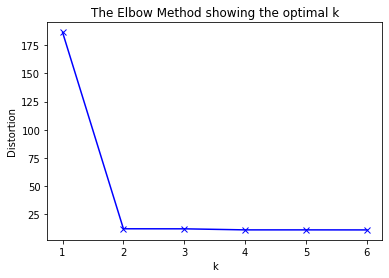

In [36]:
from scipy.spatial.distance import cdist

distortions = []
K = range(1,7)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(nova_grouped_clustering)
    distortions.append(sum(np.min(cdist(nova_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / nova_grouped_clustering.shape[0])

# There are different distance function for spatial distance that can be passed for metric. 
# Canberra function shows clear view of elbow break point.

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Above chart shows that cluster size of **2** is good enough. Running K-Mean with clusters=3  will clearly shows the outliers. 

In [37]:
kclusters = 3

nova_grouped_clustering = nova_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nova_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:5] 


array([1, 1, 1, 2, 1])

Let's create a new dataframe that includes the cluster as well as the top **10** venues for each neighborhood.

In [38]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nova_merged = nova_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nova_merged = nova_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how='inner')

nova_merged.head() # check the last columns!

,Neighborhood,City,State,Latitude,Longitude,Annual Change (%),HPI,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,22307,Alexandria,VA,38.774863,-77.05930,4.63,684.13,1,Home Service,Pharmacy,Bank,Chinese Restaurant,Food Court,Massage Studio,Flower Shop,Liquor Store,Shopping Mall,Coffee Shop
1,22302,Alexandria,VA,38.829512,-77.08204,3.52,1037.07,1,Rental Car Location,Pizza Place,Hobby Shop,Sports Bar,Sushi Restaurant,Restaurant,Gift Shop,Bank,Bakery,Church
2,22043,Falls Church,VA,38.901311,-77.19777,-0.47,1057.79,1,Video Store,College Tennis Court,Women's Store,Eye Doctor,Fried Chicken Joint,Food Truck,Food Service,Food Court,Food & Drink Shop,Food
3,22308,Alexandria,VA,38.728464,-77.05701,0.51,902.73,1,Dance Studio,Harbor / Marina,Jewelry Store,Eye Doctor,Fried Chicken Joint,Food Truck,Food Service,Food Court,Food & Drink Shop,Food
5,20194,Reston,VA,38.977362,-77.34658,0.00,387.11,1,American Restaurant,Coffee Shop,Lake,Bank,Cosmetics Shop,Mobile Phone Shop,Mexican Restaurant,Chinese Restaurant,Salon / Barbershop,Sandwich Place


**Finally, let's visualize the resulting clusters**

In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
#kclusters=3
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nova_merged['Latitude'], nova_merged['Longitude'], nova_merged['Neighborhood'], nova_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## Analysis <a name="analysis"></a>

We can now examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.  

#### Cluster 1

In [40]:
nova_merged.loc[nova_merged['Cluster Labels'] == 0, nova_merged.columns[[1] + list(range(5, nova_merged.shape[1]))]]

,City,Annual Change (%),HPI,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,McLean,0.34,1042.47,0,Home Service,Japanese Restaurant,Fast Food Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,Food Truck,Food Service,Food Court,Food & Drink Shop,Food
15,Fairfax,7.04,716.79,0,Fast Food Restaurant,Intersection,Women's Store,Frozen Yogurt Shop,Fried Chicken Joint,Food Truck,Food Service,Food Court,Food & Drink Shop,Food
16,Burke,1.01,751.23,0,Intersection,Women's Store,Fast Food Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,Food Truck,Food Service,Food Court,Food & Drink Shop,Food
39,Springfield,5.59,797.61,0,Home Service,Intersection,Basketball Court,Deli / Bodega,Dog Run,Flower Shop,Frozen Yogurt Shop,Fried Chicken Joint,Food Truck,Food Service


#### Cluster 2

In [41]:
nova_merged.loc[nova_merged['Cluster Labels'] == 1, nova_merged.columns[[1] + list(range(5, nova_merged.shape[1]))]]

,City,Annual Change (%),HPI,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alexandria,4.63,684.13,1,Home Service,Pharmacy,Bank,Chinese Restaurant,Food Court,Massage Studio,Flower Shop,Liquor Store,Shopping Mall,Coffee Shop
1,Alexandria,3.52,1037.07,1,Rental Car Location,Pizza Place,Hobby Shop,Sports Bar,Sushi Restaurant,Restaurant,Gift Shop,Bank,Bakery,Church
2,Falls Church,-0.47,1057.79,1,Video Store,College Tennis Court,Women's Store,Eye Doctor,Fried Chicken Joint,Food Truck,Food Service,Food Court,Food & Drink Shop,Food
3,Alexandria,0.51,902.73,1,Dance Studio,Harbor / Marina,Jewelry Store,Eye Doctor,Fried Chicken Joint,Food Truck,Food Service,Food Court,Food & Drink Shop,Food
5,Reston,0.00,387.11,1,American Restaurant,Coffee Shop,Lake,Bank,Cosmetics Shop,Mobile Phone Shop,Mexican Restaurant,Chinese Restaurant,Salon / Barbershop,Sandwich Place
6,Springfield,2.39,665.05,1,Home Service,Bank,Middle Eastern Restaurant,Convenience Store,Golf Course,Bagel Shop,Fried Chicken Joint,Food Truck,Food Service,Food Court
7,Alexandria,2.74,1370.52,1,Lounge,Café,Pharmacy,Southern / Soul Food Restaurant,Thrift / Vintage Store,Steakhouse,Beer Garden,Gas Station,Sushi Restaurant,Bakery
8,Fairfax,1.44,788.15,1,Vietnamese Restaurant,Gym,Dog Run,Women's Store,Eye Doctor,Fried Chicken Joint,Food Truck,Food Service,Food Court,Food & Drink Shop
10,Alexandria,1.29,750.96,1,Pizza Place,Discount Store,Drugstore,Sandwich Place,Clothing Store,Liquor Store,Shoe Store,Grocery Store,Indian Restaurant,Gym / Fitness Center
11,Alexandria,4.59,716.87,1,Yoga Studio,Track,Dance Studio,Diner,Discount Store,Frozen Yogurt Shop,Fried Chicken Joint,Food Truck,Food Service,Food Court


#### Cluster 3

In [42]:
nova_merged.loc[nova_merged['Cluster Labels'] == 2, nova_merged.columns[[1] + list(range(5, nova_merged.shape[1]))]]

,City,Annual Change (%),HPI,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Herndon,6.51,843.14,2,Pool,Women's Store,Eye Doctor,Fried Chicken Joint,Food Truck,Food Service,Food Court,Food & Drink Shop,Food,Flower Shop
56,Richmond,6.61,489.87,2,Pool,Business Service,Women's Store,Fast Food Restaurant,Fried Chicken Joint,Food Truck,Food Service,Food Court,Food & Drink Shop,Food


We can estimate the number of **1st Most Common Venue** in each cluster. Using the result, we can create a bar chart which may help us to find proper label names for each cluster.

In [43]:
count_venue = nova_merged
count_venue = count_venue.drop(['Neighborhood','City', 'State','Annual Change (%)', 'Latitude', 'Longitude','HPI'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,American Restaurant,Athletics & Sports,Convenience Store,Dance Studio,Deli / Bodega,Eastern European Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Food,Garden,Gas Station,Grocery Store,Home Service,Hotel,Intersection,Light Rail Station,Lounge,Mobile Phone Shop,Music Venue,Park,Pet Store,Pizza Place,Platform,Playground,Plaza,Pool,Rental Car Location,Sculpture Garden,Shopping Mall,Soccer Field,Spa,Thrift / Vintage Store,Video Store,Vietnamese Restaurant,Yoga Studio
0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,1,3,1,1,0,1,1,1,1,4,1,0,1,1,1,1,1,1,7,1,1,1,1,2,1,1,1,2,1,1,1,2
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0


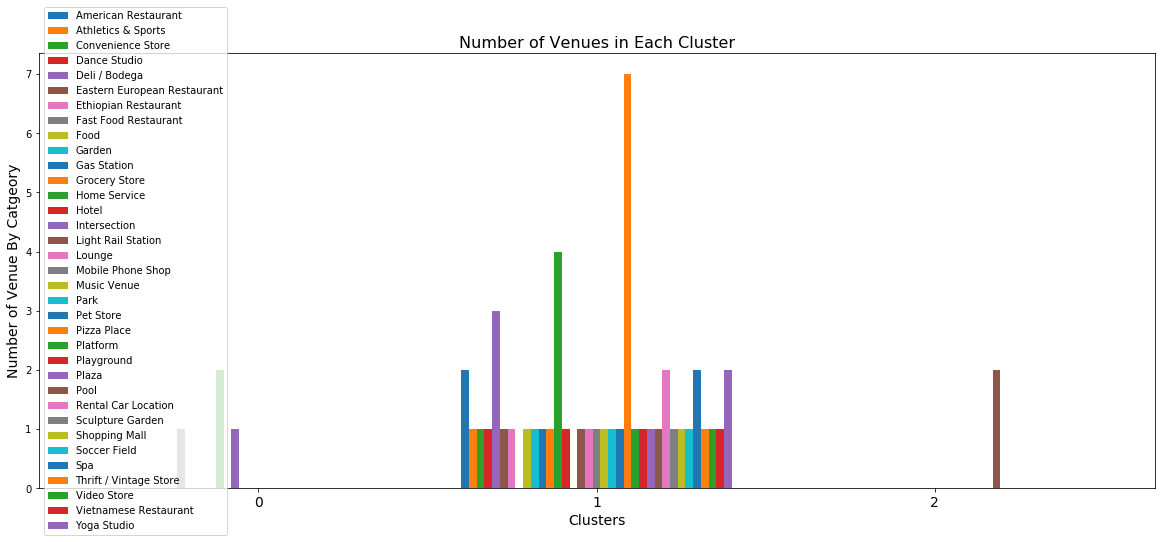

In [44]:
#creating a bar chart of "Number of Venues in Each Cluster"
frame=cv_cluster.plot.bar(figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Clusters', fontsize=14)
plt.ylabel('Number of Venue By Catgeory', fontsize=14)
plt.legend (loc=6)

When we examine above graph we can label each cluster as follows:
* Cluster 0 : "Good Locality " Based on high percentagee of increase and good HPI
* Cluster 1 : "Limited choice"
* Cluster 2 : "Moderate "  Based on lower perentagee of increase and good HPI

We can now assign those new labels to existing label of clusters:

In [45]:
Cluster_labels = pd.DataFrame({'Clusters': [0,1,2], 'Labels': ["Good Locality","Limited choice","Moderate"]})
Cluster_labels

,Clusters,Labels
0,0,Good Locality
1,1,Limited choice
2,2,Moderate


Let's analyze the housing pricce index for neighborhood and try to group them into ranges.

In [46]:
data_process= nova_merged[['Neighborhood','Cluster Labels','HPI']].reset_index()
data_process.head()

,index,Neighborhood,Cluster Labels,HPI
0,0,22307,1,684.13
1,1,22302,1,1037.07
2,2,22043,1,1057.79
3,3,22308,1,902.73
4,5,20194,1,387.11


We can examine that what is the frequency of HPI in different ranges. Thus, histogram can help to visualization

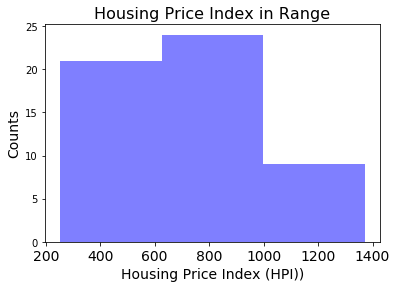

In [47]:
num_bins = 3
n, bins, patches = plt.hist(data_process['HPI'], num_bins, facecolor='blue', alpha=0.5)
plt.title("Housing Price Index in Range",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Housing Price Index (HPI))', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()

#### As it seems in above histogram, we can define the ranges as below:

* 200-600 HPI   : "Low HPI" 
* 600-1000 HPI  : "Moderate HPI" 
* 1000-1400 HPI : "High HPI" 

In this case, we can create **"Level_labels"** with those levels.

In [48]:
level = []
for i in range(0,len(data_process)):
    if (data_process['HPI'][i] < 600):
        level.append("Low HPI")
    elif (data_process['HPI'][i] >= 600 and data_process['HPI'][i] < 1000):
        level.append("Moderate HPI")
    else:
        level.append("High HPI")   

data_process['Level_labels'] = level
data_process.head()

,index,Neighborhood,Cluster Labels,HPI,Level_labels
0,0,22307,1,684.13,Moderate HPI
1,1,22302,1,1037.07,High HPI
2,2,22043,1,1057.79,High HPI
3,3,22308,1,902.73,Moderate HPI
4,5,20194,1,387.11,Low HPI


Let us findout  top 3 venues information for each Neighborhood. 

In [49]:
Top_three = nova_venues.groupby(['Neighborhood','Venue Category']).size().reset_index(name='Counts')
Top_three = Top_three.sort_values(['Neighborhood','Counts'],ascending=False).groupby('Neighborhood').head(3).reset_index(drop=True)

Top_three['Top_3'] = Top_three['Counts'].map(str) + " " + Top_three['Venue Category']
Top_three = Top_three.groupby(['Neighborhood'])['Top_3'].apply(", ".join).reset_index()

Top_three.head()

,Neighborhood,Top_3
0,20147,"1 BBQ Joint, 1 Deli / Bodega, 1 Furniture / Ho..."
1,20151,"1 Asian Restaurant, 1 Automotive Shop, 1 Brewery"
2,20170,1 Playground
3,20171,1 Pool
4,20175,"1 Athletics & Sports, 1 BBQ Joint"


## Results and Discussion <a name="results"></a>

#### Let's merge those new variables with related cluster informations in our main **nova_merged** table.

In [50]:

result = pd.merge(nova_merged, 
                    Top_three[['Neighborhood', 'Top_3']],
                    left_on = 'Neighborhood',
                    right_on = 'Neighborhood',
                    how = 'left')
result= pd.merge(result, 
                    Cluster_labels[['Clusters', 'Labels']],
                    left_on = 'Cluster Labels',
                    right_on = 'Clusters',
                    how = 'left')
result = pd.merge(result, 
                    data_process[['Neighborhood', 'Level_labels']],
                    left_on = 'Neighborhood',
                    right_on = 'Neighborhood',
                    how = 'left')

result = result.drop(['Clusters'], axis=1)
result.head(3)

,Neighborhood,City,State,Latitude,Longitude,Annual Change (%),HPI,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Top_3,Labels,Level_labels
0,22307,Alexandria,VA,38.774863,-77.05930,4.63,684.13,1,Home Service,Pharmacy,Bank,Chinese Restaurant,Food Court,Massage Studio,Flower Shop,Liquor Store,Shopping Mall,Coffee Shop,"3 Home Service, 2 Pharmacy, 1 Bakery",Limited choice,Moderate HPI
1,22302,Alexandria,VA,38.829512,-77.08204,3.52,1037.07,1,Rental Car Location,Pizza Place,Hobby Shop,Sports Bar,Sushi Restaurant,Restaurant,Gift Shop,Bank,Bakery,Church,"2 Pizza Place, 2 Rental Car Location, 1 Bakery",Limited choice,High HPI
2,22043,Falls Church,VA,38.901311,-77.19777,-0.47,1057.79,1,Video Store,College Tennis Court,Women's Store,Eye Doctor,Fried Chicken Joint,Food Truck,Food Service,Food Court,Food & Drink Shop,Food,"1 College Tennis Court, 1 Video Store",Limited choice,High HPI


#### You can now see **Top_3**, **Labels**  and  **Level_labels** columns as the last three ones in above table.

**Map of Cluster Results**

Let's visualize data with labels added.

In [51]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, top3, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['Neighborhood'], result['Labels'], result['Top_3'], result['Cluster Labels'], result['Level_labels']):
    label = folium.Popup(str(poi) + " / " + str(cluster) + "-" + str(label) + " / " + str(top3), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color= rainbow[cluster_number-1],
        popup=label,
        fill_color = rainbow[cluster_number-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

As previously noted, **Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood (Zipcode) and Venues.

**Note:** Richmond, Virginia is south of Washington D.C.

Most of the neighborhood selected belongs to cluster 3. Richmond, VA also has many area that are part of cluster 3. This shows
that it is easier for people in Northern Virginia to retire in Richmond as similar amenities are available in Richmond. Also, there are 
many areas in Richmond with positive price change and higher HPI.

## Conclusion <a name="conclusion"></a>

When people retire, they try to move to a place where cost of living is less, any tax break and most importantly, amenities. People get accustomed to certain life style and it is difficult to change immediately.
Moving to closer place which meets the needs is one option. For people in NoVA area, Richmond, VA ,seems to match the criteria mentioned. 

Main purpose of the project is to help retirees. The methodology can also be used by service provider to develop web page that allows filtering based on HPI. The criterion of retirement place selection varies from individual to individual.



 
 ## Reference <a name="reference"></a>


* [1] [Kiplinger Personal Finance Magazine]( https://www.kiplinger.com/slideshow/retirement/T006-S002-12-smart-places-to-retire/index.html)
* [2] [HPI Definition](https://www.investopedia.com/terms/h/house-price-index-hpi.asp)
* [3] [Virginia zipcode level geo spatial data](https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/)
* [4] [FHFA House Price Index](https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx#qpo)
* [5] [NOVA Wiki](https://en.wikipedia.org/wiki/Northern_Virginia)
* [6] [Washington Metroploitan Area Wiki](https://en.wikipedia.org/wiki/Washington_metropolitan_area)                              
* [7] [Forsquare API](https://developer.foursquare.com/docs)


**Thank You**

The project work is immensely helped by excellent training Notebook, titled "Segmenting and Clustering Neighborhoods in New York City"  created by     
[Alex Aklson](https://www.linkedin.com/in/aklson/) and [Polong Lin](https://www.linkedin.com/in/polonglin/), which was part of   **Coursera** course *Applied Data Science Capstone*.
Also reviewed , blogpost example provided [Blogpost:]( https://cocl.us/coursera_capstone_blogpost)
